# NYT Articles & Comments NER Analysis

This notebook extracts New York Times (NYT) articles about Ozempic, scrapes user comments, and applies Named Entity Recognition (NER) to analyze entity distributions.


## Step 1: Importing Necessary Libraries

In [13]:
from pynytimes import NYTAPI
import pandas as pd
from nytimes_scraper.nyt_api import NytApi
from nytimes_scraper.comments import fetch_comments_by_article, comments_to_df
import spacy
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import time
import nltk

## 1. Collecting NYT Articles

### Objective
Fetch articles related to Ozempic from the New York Times API and save them as a CSV file.

### Process
- Uses the NYT Article Search API to retrieve relevant articles.
- Extracts the headline, abstract, URL, and publication date.
- Saves results to `ozempic2_articles.csv`.

### Why This Matters
Understanding how major publications cover Ozempic provides insight into how media frames its impact.

In [15]:

# Initialize NYT API with your key
nyt = NYTAPI('1M1MqVkrWEhPeUpiGbqzBVYCVPHcufTu', parse_dates=True)  # Replace with your NYT API key

# Fetch Ozempic articles
print("Fetching articles about Ozempic...")
articles = nyt.article_search(
    query='ozempic',
    results=100  # Adjust this number as needed (max 100 per call)
)

# Convert to DataFrame
article_data = []
for article in articles:
    article_data.append({
        'title': article.get('headline', {}).get('main', ''),  # Main headline
        'abstract': article.get('abstract', ''),
        'url': article.get('web_url', ''),
        'published_date': article.get('pub_date', '')
    })
df = pd.DataFrame(article_data)

# Display the results
print("\nOzempic Articles:")
display(df[['title', 'published_date', 'url']])

# Optional: Save to CSV
df.to_csv('ozempic2_articles.csv', index=False)
print("Articles saved to 'ozempic2_articles.csv'")

Fetching articles about Ozempic...


C:\Users\nikhi\anaconda3\Lib\site-packages\pynytimes\helpers\article_search.py:33: UserWarning: Asking for a lot of results, because of rate limits it can take a while.
  warnings.warn(



Ozempic Articles:


,title,published_date,url
0,"Trump’s Call with Putin, and Ozempic’s Effect ...",2025-02-13 11:00:16+00:00,https://www.nytimes.com/2025/02/13/podcasts/th...
1,On a Mission to Heal Gila Monsters,2025-02-16 10:00:46+00:00,https://www.nytimes.com/2025/02/16/science/gil...
2,"Ozempic Can Curb Drinking, New Research Shows",2025-02-12 16:03:05+00:00,https://www.nytimes.com/2025/02/12/well/ozempi...
3,"The Physicians Really Are Healing Themselves, ...",2025-02-10 10:00:36+00:00,https://www.nytimes.com/2025/02/10/health/doct...
4,Drug Similar to Ozempic Failed to Treat Parkin...,2025-02-04 23:30:04+00:00,https://www.nytimes.com/2025/02/04/health/park...
...,...,...,...
95,Which Weight Loss Drug Should You Choose (if Y...,2024-07-19 09:03:11+00:00,https://www.nytimes.com/2024/07/19/health/ozem...
96,The Promise of Weight-Loss Drugs,2024-06-24 10:19:07+00:00,https://www.nytimes.com/2024/06/24/briefing/oz...
97,"In States That Won’t Pay for Obesity Drugs, ‘T...",2024-06-25 14:04:29+00:00,https://www.nytimes.com/2024/06/25/health/obes...
98,A New Option to Treat Sleep Apnea: Weight-Loss...,2024-06-21 19:45:03+00:00,https://www.nytimes.com/2024/06/21/well/sleep-...


Articles saved to 'ozempic2_articles.csv'


## 2. Scraping NYT Comments

### Objective
Extract user comments from NYT articles and store them with metadata.

### Process
- Reads article URLs from `ozempic_articles.csv`.
- Uses the NYT Community API to fetch user comments.
- Stores article title, comment text, and timestamps in `ozempic_comments.csv`.

### Why This Matters
Comparing comments versus articles highlights public perception versus media narratives.


In [ ]:

def read_urls_from_csv(file_path):
    """
    Reads a CSV file and extracts article URLs and titles.
    
    Parameters:
    file_path (str): Path to the CSV file containing article URLs.
    
    Returns:
    pd.DataFrame: A DataFrame containing article URLs and titles.
    """
    df = pd.read_csv("C:/Users/nikhi/OneDrive/Desktop/Python/Advanced Programming/ozempic2_articles.csv")
    df.columns = df.columns.str.strip()
    print("Columns in the CSV file:", df.columns)
    articles_df = df[['url', 'title']].copy()
    return articles_df

def process_comment_thread(comment, article_url, article_title, all_comments):
    """
    Recursively process a comment and its replies, adding article metadata to each.
    
    Parameters:
    comment (dict): The comment to process
    article_url (str): The URL of the article
    article_title (str): The title of the article
    all_comments (list): List to store all processed comments
    """
    # Add article metadata to the current comment
    comment['article_url'] = article_url
    comment['article_title'] = article_title
    
    # Store the processed comment
    all_comments.append(comment)
    
    # Process replies if they exist
    if 'replies' in comment and comment['replies']:
        for reply in comment['replies']:
            process_comment_thread(reply, article_url, article_title, all_comments)

def fetch_comments_for_urls(api, articles_df):
    """
    Fetch comments for articles and preserve article metadata for all comments and replies.
    
    Parameters:
    api (NytApi): An instance of the NytApi class.
    articles_df (pd.DataFrame): DataFrame containing article URLs and titles.
    
    Returns:
    List[dict]: A list of comment dictionaries with article metadata.
    """
    all_comments = []
    
    for _, article in articles_df.iterrows():
        url = article['url']
        title = article['title']
        
        try:
            print(f"Fetching comments for: {title}")
            comments = fetch_comments_by_article(api, url)
            
            # Process each top-level comment and its replies
            for comment in comments:
                process_comment_thread(comment, url, title, all_comments)
                
        except Exception as e:
            print(f"Error fetching comments for {url}: {e}")
    
    return all_comments

def save_comments_to_csv(comments, output_file):
    """
    Save comments with article metadata to a CSV file.
    
    Parameters:
    comments (List[dict]): A list of comment dictionaries with article metadata.
    output_file (str): Path to the output CSV file.
    """
    if comments:
        # Convert the comments to a DataFrame
        comment_df = comments_to_df(comments)
        
        # Ensure article metadata columns are first
        metadata_cols = ['article_url', 'article_title']
        other_cols = [col for col in comment_df.columns if col not in metadata_cols]
        comment_df = comment_df[metadata_cols + other_cols]
        
        # Save the DataFrame to a CSV file
        comment_df.to_csv(output_file, index=False)
        print(f"Comments saved to {output_file}")
        
        # Print summary statistics
        print(f"\nSummary:")
        print(f"Total number of comments: {len(comment_df)}")
        print(f"Number of articles with comments: {comment_df['article_url'].nunique()}")
        print(f"Number of top-level comments: {len(comment_df[comment_df['parentID'].isna()])}")
        print(f"Number of replies: {len(comment_df[comment_df['parentID'].notna()])}")
        
        # Verify metadata consistency
        missing_metadata = comment_df[comment_df['article_url'].isna() | comment_df['article_title'].isna()]
        if not missing_metadata.empty:
            print(f"\nWarning: {len(missing_metadata)} comments are missing article metadata")
    else:
        print("No comments found!")

def main(input_csv, output_csv, api_key):
    """
    Main function to orchestrate the comment collection process.
    
    Parameters:
    input_csv (str): Path to the input CSV file containing article URLs.
    output_csv (str): Path to the output CSV file to save comments.
    api_key (str): NYTimes API key.
    """
    api = NytApi(api_key)
    articles_df = read_urls_from_csv(input_csv)
    comments = fetch_comments_for_urls(api, articles_df)
    save_comments_to_csv(comments, output_csv)

# Example usage
if __name__ == "__main__":
    input_csv = "ozempic2_articles.csv"
    output_csv = "nytimes_comments_with_metadata.csv"
    api_key = '1M1MqVkrWEhPeUpiGbqzBVYCVPHcufTu' # Replace with your actual API key
    
    main(input_csv, output_csv, api_key)

## 3. Named Entity Recognition (NER) Analysis

### Objective
Apply NER to articles and comments to extract key entities such as people, locations, and organizations.

### Process
- Uses spaCy for NER analysis.
- Custom rule added to tag Ozempic as a `PRODUCT`.
- Extracts named entities and categorizes them.
- Saves results to `ozempic_articles_with_entities.csv` and `ozempic_comments_with_entities.csv`.

### Why This Matters
Identifying entities helps analyze how different subjects (companies, people, places) are associated with Ozempic.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading CSVs...
Loaded in 0.63 seconds
Articles with 'ozempic': 74 out of 100
Articles: 100, Top Comments: 15039
Preprocessing articles...
Articles preprocessed in 0.03 seconds
Preprocessing comments...


C:\Users\nikhi\AppData\Local\Temp\ipykernel_22364\2617794730.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comments_df['tokens'] = top_comments_df['commentBody'].apply(preprocess)
C:\Users\nikhi\AppData\Local\Temp\ipykernel_22364\2617794730.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comments_df['clean_text'] = top_comments_df['tokens'].apply(' '.join)


Comments preprocessed in 3.38 seconds
Running NER on articles...
Articles NER done in 0.14 seconds
Running NER on comments...
Comments NER done in 32.93 seconds

Entity Type Counts in Articles:


C:\Users\nikhi\AppData\Local\Temp\ipykernel_22364\2617794730.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comments_df['entities'] = extract_entities_batch(top_comments_df['clean_text'])


label
CARDINAL    18
PERSON      14
GPE          9
DATE         9
NORP         8
ORG          7
ORDINAL      2
LOC          1
Name: count, dtype: int64


Entity Type Counts in Comments:


label
PERSON         4754
DATE           4269
CARDINAL       2837
ORG            2679
NORP           1757
GPE            1002
ORDINAL         666
TIME            322
LOC             183
MONEY           125
QUANTITY         72
PRODUCT          43
FAC              17
PERCENT          10
EVENT             8
LAW               4
WORK_OF_ART       1
Name: count, dtype: int64

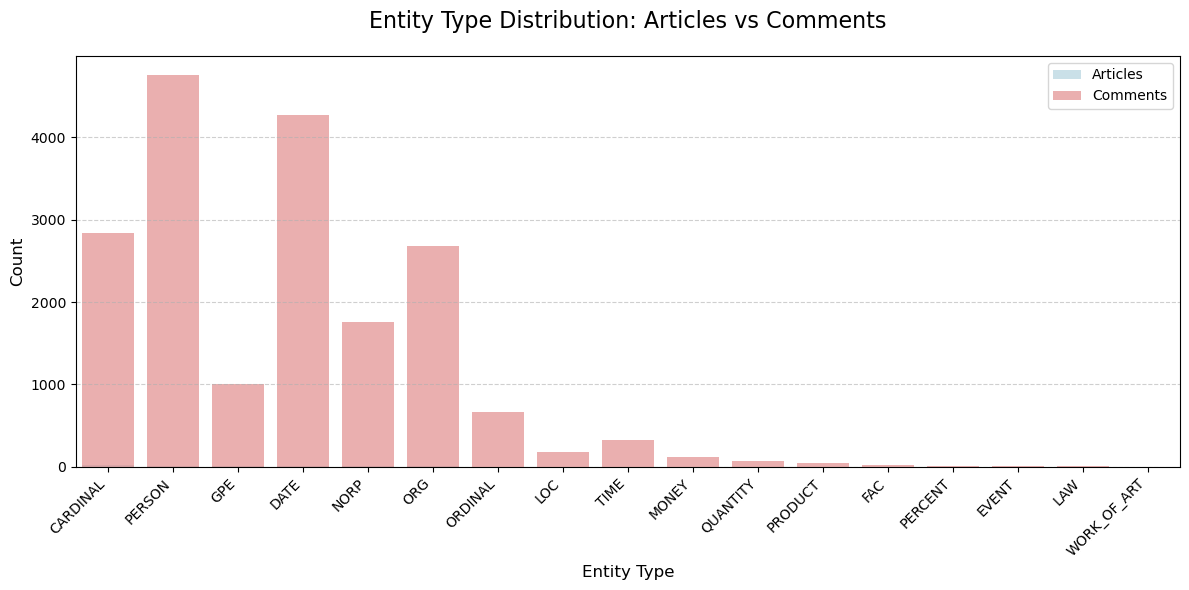

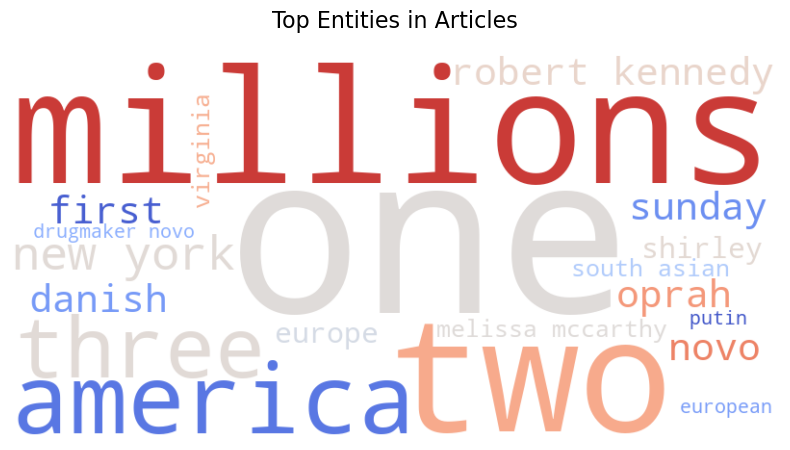

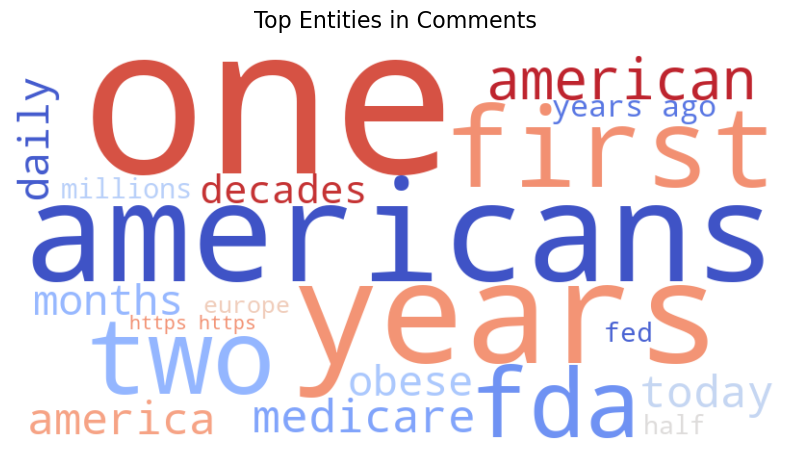

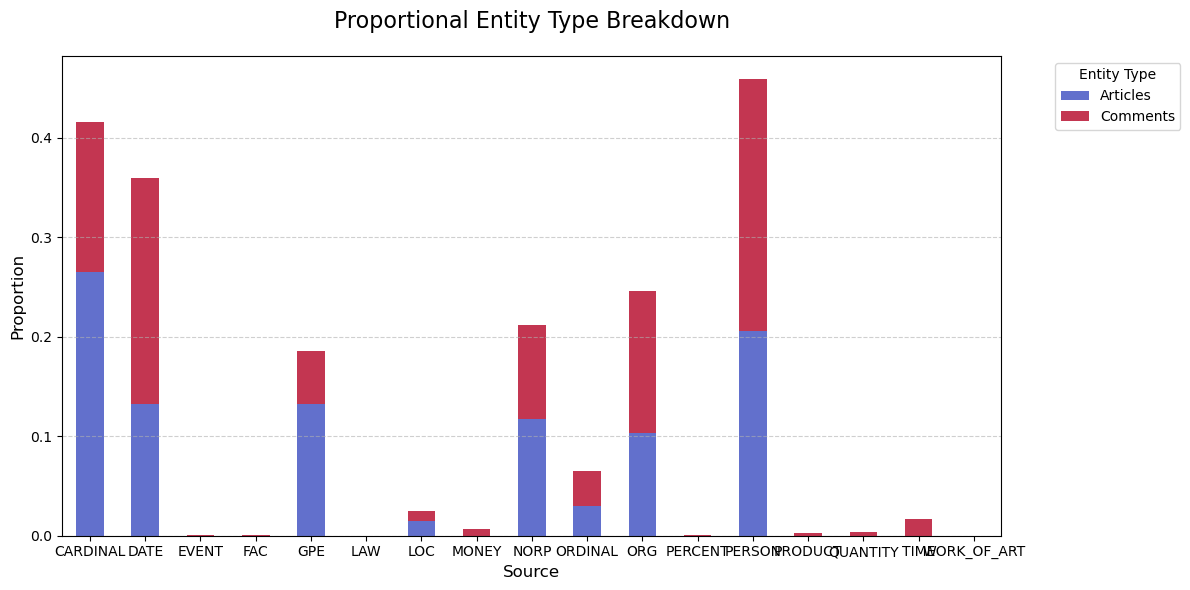


Saved articles with entities to 'ozempic2_articles_with_entities.csv'
Saved comments with entities to 'nytimes_comments_with_entities.csv'

Example Entities from Articles:
Article: Trump’s Call with Putin, and Ozempic’s Effect on Drinking
Entities: [('putin', 'PERSON')]

Article: On a Mission to Heal Gila Monsters
Entities: []

Article: Ozempic Can Curb Drinking, New Research Shows
Entities: []

Article: The Physicians Really Are Healing Themselves, With Ozempic
Entities: []

Article: Drug Similar to Ozempic Failed to Treat Parkinson’s Disease in a Trial
Entities: []


Example Entities from Comments:
Comment: Very cool! Gratified know scientists give back to the very creatures that benefit us humans, including myself. I started taking Ozempic for type 2 diabetes just before the new New Year. I had no idea it was derived from the venom of gila monsters. I can now add it to the list of absolute miracles that abound in nature. Thank you for this article.
Entities: []

Comment: Thanks for

In [20]:

nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model with only NER and custom rule for Ozempic
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'lemmatizer'])
ruler = nlp.add_pipe("entity_ruler", before="ner")
ruler.add_patterns([{"label": "PRODUCT", "pattern": "Ozempic"}])

# Load CSVs
print("Loading CSVs...")
start = time.time()
articles_df = pd.read_csv('ozempic2_articles.csv')
comments_df = pd.read_csv('nytimes_comments_with_metadata.csv')
print(f"Loaded in {time.time() - start:.2f} seconds")

# Verify article relevance (check if Ozempic is in text)
articles_df['contains_ozempic'] = articles_df['title'].str.contains('ozempic', case=False, na=False) | \
                                  articles_df['abstract'].str.contains('ozempic', case=False, na=False)
print(f"Articles with 'ozempic': {articles_df['contains_ozempic'].sum()} out of {len(articles_df)}")

# Filter to top-level comments
top_comments_df = comments_df.head(15039)  # Adjust if you have a reply column
print(f"Articles: {len(articles_df)}, Top Comments: {len(top_comments_df)}")

# Preprocessing function: Tokenize + Remove Stopwords
stop_words = set(stopwords.words('english'))

def preprocess(text):
    if pd.isna(text):
        return []
    tokens = [word.lower() for word in word_tokenize(str(text)) if word.isalpha() and word.lower() not in stop_words]
    return tokens

# Apply preprocessing
print("Preprocessing articles...")
start = time.time()
articles_df['text'] = articles_df['title'] + ' ' + articles_df['abstract'].fillna('')
articles_df['tokens'] = articles_df['text'].apply(preprocess)
articles_df['clean_text'] = articles_df['tokens'].apply(' '.join)
print(f"Articles preprocessed in {time.time() - start:.2f} seconds")

print("Preprocessing comments...")
start = time.time()
top_comments_df['tokens'] = top_comments_df['commentBody'].apply(preprocess)
top_comments_df['clean_text'] = top_comments_df['tokens'].apply(' '.join)
print(f"Comments preprocessed in {time.time() - start:.2f} seconds")

# NER with nlp.pipe
def extract_entities_batch(texts):
    return [[(ent.text, ent.label_) for ent in doc.ents] for doc in nlp.pipe(texts, batch_size=1000)]

# Apply NER
print("Running NER on articles...")
start = time.time()
articles_df['entities'] = extract_entities_batch(articles_df['clean_text'])
print(f"Articles NER done in {time.time() - start:.2f} seconds")

print("Running NER on comments...")
start = time.time()
top_comments_df['entities'] = extract_entities_batch(top_comments_df['clean_text'])
print(f"Comments NER done in {time.time() - start:.2f} seconds")

# Summarize entities
def summarize_entities(df, column_name):
    all_entities = [ent for sublist in df[column_name] for ent in sublist]
    entity_df = pd.DataFrame(all_entities, columns=['entity', 'label'])
    return entity_df['label'].value_counts(), entity_df['entity'].value_counts()

article_label_counts, article_entity_freq = summarize_entities(articles_df, 'entities')
comment_label_counts, comment_entity_freq = summarize_entities(top_comments_df, 'entities')

# Display summaries
print("\nEntity Type Counts in Articles:")
display(article_label_counts)
print("\nEntity Type Counts in Comments:")
display(comment_label_counts)

# 🔹 Visual 1: Bar Chart (Standard White Background)
plt.figure(figsize=(12, 6))
sns.barplot(x=article_label_counts.index, y=article_label_counts.values, color='lightblue', label='Articles', alpha=0.7)
sns.barplot(x=comment_label_counts.index, y=comment_label_counts.values, color='lightcoral', label='Comments', alpha=0.7)
plt.title('Entity Type Distribution: Articles vs Comments', fontsize=16, pad=20)
plt.xlabel('Entity Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 🔹 Visual 2: Word Clouds (Light Background)
def plot_wordcloud(freq_series, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm',
                          max_words=20).generate_from_frequencies(freq_series)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16, pad=20)
    plt.axis('off')
    plt.show()

plot_wordcloud(article_entity_freq.nlargest(20).to_dict(), 'Top Entities in Articles')
plot_wordcloud(comment_entity_freq.nlargest(20).to_dict(), 'Top Entities in Comments')

# 🔹 Visual 3: Stacked Bar Chart (Neutral Color Theme)
combined_counts = pd.DataFrame({
    'Articles': article_label_counts / article_label_counts.sum(),
    'Comments': comment_label_counts / comment_label_counts.sum()
}).fillna(0).T

plt.figure(figsize=(12, 6))
combined_counts.T.plot(kind='bar', stacked=True, colormap='coolwarm', alpha=0.8, ax=plt.gca())
plt.title('Proportional Entity Type Breakdown', fontsize=16, pad=20)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Entity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Save results
articles_df.to_csv('ozempic2_articles_with_entities.csv', index=False)
top_comments_df.to_csv('nytimes_comments_with_entities.csv', index=False)
print("\nSaved articles with entities to 'ozempic2_articles_with_entities.csv'")
print("Saved comments with entities to 'nytimes_comments_with_entities.csv'")

# Example entities
print("\nExample Entities from Articles:")
for i, row in articles_df.head().iterrows():
    print(f"Article: {row['title']}")
    print(f"Entities: {row['entities']}\n")

print("\nExample Entities from Comments:")
for i, row in top_comments_df.head().iterrows():
    print(f"Comment: {row['commentBody']}")
    print(f"Entities: {row['entities']}\n")

## 4. Visualizing Named Entities

### Visualizations
- **Bar Chart:** Distribution of entity types in articles versus comments.
- **Word Cloud:** Most frequently mentioned named entities in each dataset.

### Takeaways
- Articles contain more structured entities like `ORG` (organizations) and `GPE` (locations).
- Comments contain more `PERSON` entities, showing public figures referenced.
- Highlights how journalistic coverage differs from public discourse.


## Saving Visuals as PNG's

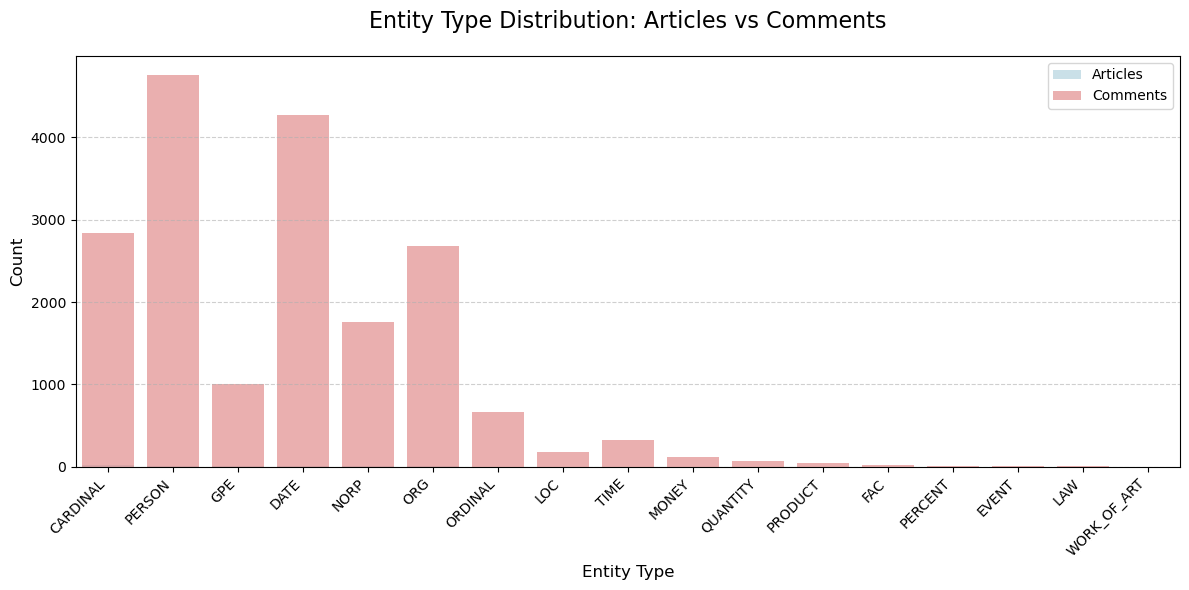

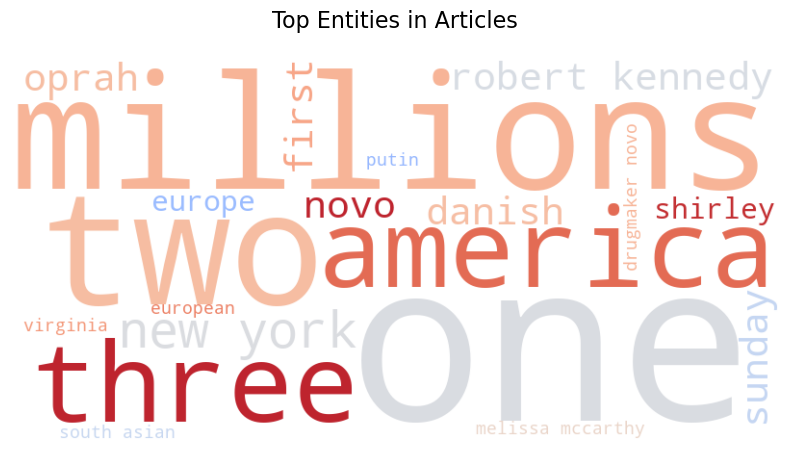

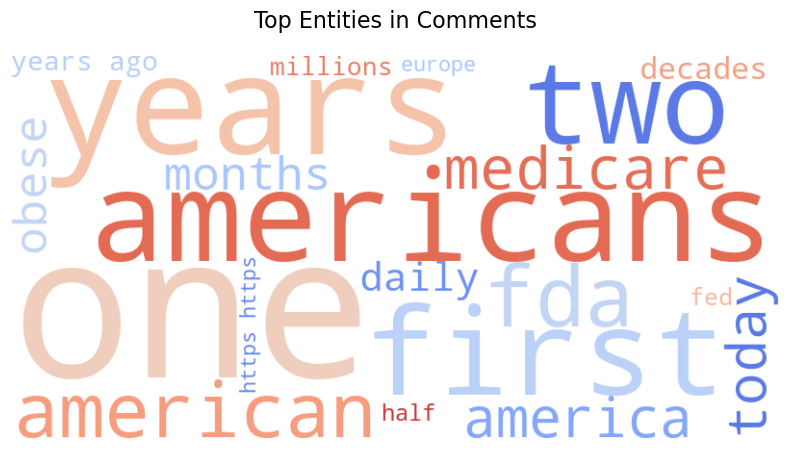

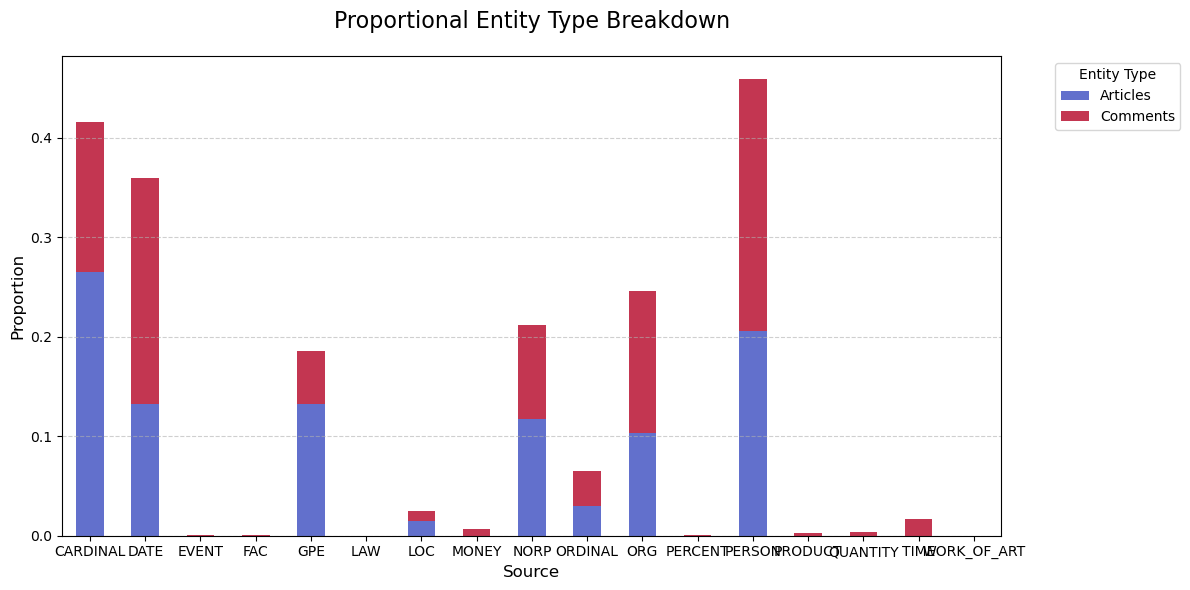

In [22]:
import os

# Ensure the output directory exists
output_dir = "visuals"
os.makedirs(output_dir, exist_ok=True)

# 🔹 Visual 1: Bar Chart (Standard White Background) - Saves as PNG
plt.figure(figsize=(12, 6))
sns.barplot(x=article_label_counts.index, y=article_label_counts.values, color='lightblue', label='Articles', alpha=0.7)
sns.barplot(x=comment_label_counts.index, y=comment_label_counts.values, color='lightcoral', label='Comments', alpha=0.7)
plt.title('Entity Type Distribution: Articles vs Comments', fontsize=16, pad=20)
plt.xlabel('Entity Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "entity_distribution.png"), dpi=300, bbox_inches='tight')
plt.show()

# 🔹 Visual 2: Word Clouds (Light Background) - Saves as PNG
def plot_wordcloud(freq_series, title, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm',
                          max_words=20).generate_from_frequencies(freq_series)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16, pad=20)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()

plot_wordcloud(article_entity_freq.nlargest(20).to_dict(), 'Top Entities in Articles', "wordcloud_articles.png")
plot_wordcloud(comment_entity_freq.nlargest(20).to_dict(), 'Top Entities in Comments', "wordcloud_comments.png")

# 🔹 Visual 3: Stacked Bar Chart (Neutral Color Theme) - Saves as PNG
plt.figure(figsize=(12, 6))
combined_counts.T.plot(kind='bar', stacked=True, colormap='coolwarm', alpha=0.8, ax=plt.gca())
plt.title('Proportional Entity Type Breakdown', fontsize=16, pad=20)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Entity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "entity_proportions.png"), dpi=300, bbox_inches='tight')
plt.show()


## 5. Conclusion and Next Steps

- Compare sentiment of articles versus comments.
- Expand entity analysis to detect trends over time.
- Use topic modeling to find discussion patterns in user comments.